## Problem 1

Consider reaction-diffusion equation with periodic boundary condition

$$u_t(x,t) = u_{xx}(x,t) + \varepsilon u^2,\quad x\in [0,2\pi],$$

$$u(x,0)=e^{-5(x-\pi)^2}, \quad u(0,t)=u(2\pi,t), u_x(0,t)=u_x(2\pi,t).\quad $$

Here $\varepsilon = 1.0$. Use second order finite difference discretization with uniform grid spacing $\Delta x=2\pi/100$.

Obtain the solution $u(x,T)$ at $T=6.0$ using the following methods.

a) Implement a `ForwardEuler` method, using the forward Euler for time discretization and $\Delta t=0.001$.

b) Implement a `CNBroyden` method, using a trapezoidal rule for time discretization and $\Delta t = 0.1$. This is also called the Crank-Nicolson method. Use any type of Broyden's method to solve the nonlinear equation. The starting guess for Broyden's matrix can be chosen as $B_0=\alpha I$, $\alpha=0.05$. Plot the number of iterations of Broyden's method for each step to reach certain stopping criterion (say $10^{-8}$).

Hint: the simplest version of Broyden's method to implement is the rank-1 update version with limited history of size 1.

In [3]:
using LinearAlgebra
using SparseArrays

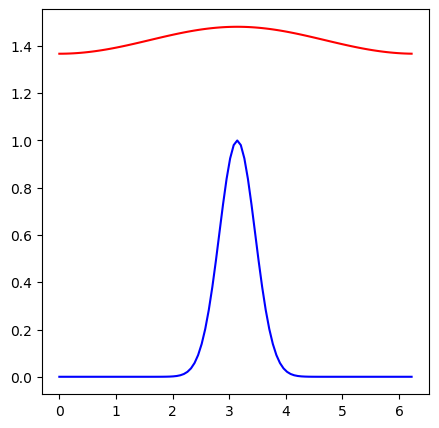

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f744a3e7310>

In [6]:
using LinearAlgebra
using SparseArrays

function ForwardEuler(N,T,u0,A,epsil)
    dims = size(A)
    u = spzeros(dims[2], N+1)
    u[:, 1] = u0
    h = T/N
    
    for i = 1:N
        u[:,i+1] = u[:,i] + h*(A*u[:,i] + epsil*u[:,i].^2)
    end
    
    return u
end

Ls = 2*pi
Ns = 100
hs = Ls / Ns
xs = collect(0:Ns-1)*hs

A = 1.0/hs^2 * spdiagm(-1=>ones(Ns-1),0=>-2.0*ones(Ns),1=>ones(Ns-1))
A[1,Ns] = 1.0 / hs^2
A[Ns,1] = 1.0 / hs^2
u0 = exp.(-5.0*(xs.-pi).^2)

T  = 6.0
dt = 0.001
N  = round(Int64,T/dt)
t  = collect(0:N)*dt
epsil = 1.0

uForwardEuler = ForwardEuler(N,T,u0,A,epsil)

using PyPlot
figure(1,figsize=(5,5))
plot(xs,vec(uForwardEuler[:,1]),"b-")
plot(xs,vec(uForwardEuler[:,N]),"r-")



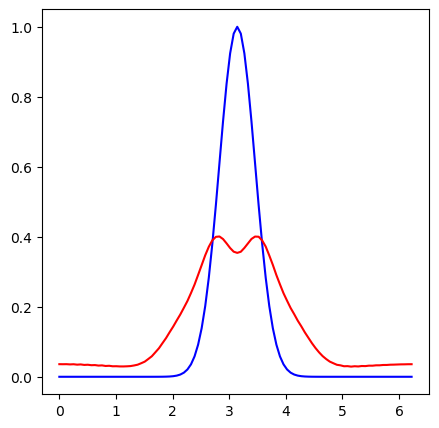

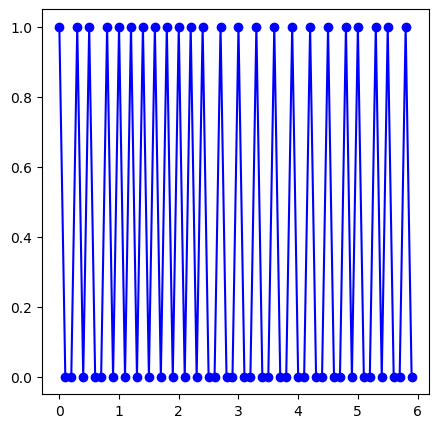

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f744a317650>

In [7]:
function CNBroyden(N,T,u0,A,epsil,alpha,maxIter)
    dims = size(A)
    u = spzeros(dims[2], N+1)
    u[:, 1] = u0
    h = T/N
    
    # F(u) = 0. u: previous two iterations of u
    F(uₙ, uₙ₋₁) = uₙ - h/2*A*uₙ - epsil*h/2*uₙ.^2 - (uₙ₋₁ + h/2*(A*uₙ₋₁ + epsil*uₙ₋₁.^2))
    # Inverse Jacobian approximations; Bₙ and Bₙ₋₁
#     Bₙ⁻¹ = spzeros(dims[1],dims[])
    α = alpha
#     Bₙ₋₁⁻¹ = α*sparse(I,dims[1],dims[2])
    B⁻¹ = α*sparse(I,dims[1],dims[2])
    # do one step of newtons
    u[:, 2] =  u[:, 1] + h*(A*u[:,1] + epsil*u[:,1].^2)
    
    Niter = spzeros(N)
    Niter[1] = 1
    for i = 2:N
        # advance solution
        u_new = u[:,i+1]
        u_old = u[:,i]
        u_oldold = u[:,i-1]
#         l=1
        for l = 1 : maxIter
            u_new = u_old - B⁻¹*F(u_old,u_oldold)
            if(norm(u_new-u_old, Inf) < 1e-14)
                Niter[i] = l
                break
            end
            # advance inverse jacobian
            ΔF = F(u_new, u_old)- F(u_old, u_oldold)
            Δu = u_new - u_old
            B⁻¹ = B⁻¹ + (Δu - B⁻¹*ΔF)*ΔF'/(norm(ΔF,2).^2)
        end
#         Niter[i] = l
        u[:,i+1] = u_new
#         u[:,i+1] = u[:,i] - B⁻¹*F(u[:, i],u[:, i-1])
#         # advance inverse jacobian
#         ΔF = F(u[:, i+1],u[:, i]) - F(u[:, i],u[:, i-1])
#         Δu = u[:, i+1] - u[:, i]
#         B⁻¹ = B⁻¹ + (Δu - B⁻¹*ΔF)*ΔF'/(norm(ΔF,2).^2)
    end
    return u,Niter
end

Ls = 2*pi
Ns = 100
hs = Ls / Ns
xs = collect(0:Ns-1)*hs

A = 1.0/hs^2 * spdiagm(-1=>ones(Ns-1),0=>-2.0*ones(Ns),1=>ones(Ns-1))
A[1,Ns] = 1.0 / hs^2
A[Ns,1] = 1.0 / hs^2
u0 = exp.(-5.0*(xs.-pi).^2)

T  = 6.0
dt = 0.1
N  = round(Int64,T/dt)
t  = collect(0:N)*dt
epsil = 1.0
alpha = 0.05
maxIter = 200

uCNBroyden,Niter = CNBroyden(N,T,u0,A,epsil,alpha,maxIter)

using PyPlot
figure(1,figsize=(5,5))
plot(xs,vec(uCNBroyden[:,1]),"b-")
plot(xs,vec(uCNBroyden[:,N]),"r-")

figure(2,figsize=(5,5))
plot(t[1:N],Niter,"b-o")

## Problem 2

Use the five-point finite difference formula and solve 

$$-\Delta u(x,y) = 1, \quad u\vert_{\partial \Omega} = 0,$$

on a $L$-shaped domain (see below, blue shaded region)

$$\Omega=((0,1)\times(0,1)) \backslash ([1/2,1]\times[1/2,1]).$$

Use a grid spacing $h=1/(N+1)$ and $N=200$. 

1) Write a function `FDLshape` which returns $X,Y,U$, so that $U_{i,j}$ is the approximate solution for $u(X[i,j],Y[i,j])$. If $(X[i,j],Y[i,j])$ is not in $\Omega$, $U_{i,j}=0$. Plot the solution $U$. You can solve the equation using the backslash directly.

2) Write a function `FDLshapeCG` which does the same job, but uses the conjugate gradient solver to solve the linear system and get the same result. You should write your own CG solver instead of using external packages.

This is how you obtain (something close to) MATLAB's logo!

https://www.mathworks.com/company/newsletters/articles/the-mathworks-logo-is-an-eigenfunction-of-the-wave-equation.html

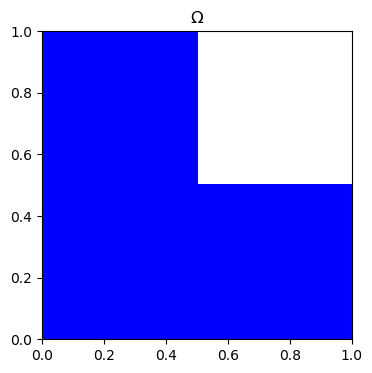

PyObject Text(0.5, 1, '$\\Omega$')

In [8]:
function ndgrid(v1::AbstractVector{T}, v2::AbstractVector{T}) where T
    m, n = length(v1), length(v2)
    v1 = reshape(v1, m, 1)
    v2 = reshape(v2, 1, n)
    (repeat(v1, 1, n), repeat(v2, m, 1))
end

x1d=LinRange(0,1,100)
X,Y=ndgrid(x1d,x1d)
Z=zeros(size(X))
for j = 1 : prod(size(X))
    if(X[j]>=0.5 && Y[j]>=0.5)
        Z[j] = 1.0
    else
        Z[j] = 0.0
    end
end

using PyPlot
figure(1,figsize=(4,4))
contourf(X,Y,Z,[0.00,0.99,1.01],colors=("b","w"))
title(L"\Omega")

In [60]:
size(X)
size(Z)
# Z
zeros(size(X))

200-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [69]:
function FDLShape(L,N)
    h = 1/(N+1)
    X = zeros(N)
    Y = zeros(N)
    A = 1/h*spdiagm(2 => ones(N-2), 1 => ones(N-1), 0 => -4*ones(N), -1 => ones(N-1), -2 => ones(N-2))
    # periodic conditions
    A[1,end] = 1
    A[1,end-1] = 1
    A[2,end] = 1
    A[end,end] = 1
    A[end,end-1] = 1
    A[end-1,end-1] = 1
    # boundary conditions ?????

    # what are X and Y supposed to be?
    x1d=LinRange(0,L,N)
    X,Y=ndgrid(x1d,x1d)
#     X = A[:,1]
#     Y = A[1,:]
    # ...
    
    U = A\ones(N)
    # Boundary conditions
    U[1:3] = [0,0,0]
    U[end-2:end] = [0,0,0]
    U = diagm(1=>U[2:3:end-1], 0 => U[1:3:end],-1 => U[3:3:end-1])
    return X,Y,U
end

X,Y,U = FDLShape(1.0,200)
h=figure(1,figsize=(5,5))
ax = h.add_subplot(111, projection="3d")
# surf(X,Y,U,edgecolors="none",cmap=ColorMap("jet"),shade="true")
plot_surface(X,Y,U, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.8, linewidth=0.25)
# contourf(X,Y,U,edgecolors="none",cmap=ColorMap("jet"),shade="true")
ax.view_init(elev=30.0,azim=120.0)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/aa/users/cs199-byb/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('shape mismatch: objects cannot be broadcast to a single shape')
  File "/home/aa/users/cs199-byb/tmp/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 1621, in plot_surface
    X, Y, Z = np.broadcast_arrays(X, Y, Z)
  File "<__array_function__ internals>", line 6, in broadcast_arrays
  File "/home/aa/users/cs199-byb/tmp/anaconda3/lib/python3.7/site-packages/numpy/lib/stride_tricks.py", line 264, in broadcast_arrays
    shape = _broadcast_shape(*args)
  File "/home/aa/users/cs199-byb/tmp/anaconda3/lib/python3.7/site-packages/numpy/lib/stride_tricks.py", line 191, in _broadcast_shape
    b = np.broadcast(*args[:32])


In [70]:
U = [1, 2, 3, 4, 5, 6,7,8,9,10,11,12,24]
U[1:3] = [0,0,0]
U[end-2:end]
collect(1.0:5)
U[1:3:end]
length(U)

13

In [36]:
# Conjugate gradient solver

function CG(A,b,x0,tol=1e-5,maxit=1000)
    x  = x0
    r = b - A*x
    p = r
    for i = 1:length(b)
        α = r'*r/(p'*A*p)
        x = x + α*p
        rᵢ₊₁ = r - α*A*p
        if r < tol
            break
        end
        β = rᵢ₊₁'*rᵢ₊₁/(r'*r)
        p = rᵢ₊₁ + β*p
        r = rᵢ₊₁
    end
        
    return x
end


function FDLShapeCG(L,N)
    
    A = 1/h*spdiagm(2 => ones(N-2), 1 => ones(N-1), 0 => -4*ones(N), -1 => ones(N-1), -2 => ones(N-2))
    # periodic conditions
    A[1,end] = 1
    A[1,end-1] = 1
    A[2,end] = 1
    A[end,end] = 1
    A[end,end-1] = 1
    A[end-1,end-1] = 1
    # ...

    """ """
    U = CG(A,ones(N), """ initial guess """) # 
    return X,Y,U
end

X,Y,UCG = FDLShapeCG(1.0,200)
h=figure(1,figsize=(5,5))
ax = h.add_subplot(111, projection="3d")
surf(X,Y,UCG,edgecolors="none",cmap=ColorMap("jet"),shade="true")
ax.view_init(elev=30.0,azim=120.0)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")


h=figure(2,figsize=(5,5))
ax = h.add_subplot(111, projection="3d")
surf(X,Y,U-UCG,edgecolors="none",cmap=ColorMap("jet"),shade="true")
ax.view_init(elev=30.0,azim=120.0)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")


LoadError: syntax: extra token "gradient" after end of expression

## Problem 3

Consider a matrix $A\in \mathbb{R}^{N\times N}$. $A$ is diagonalizable with only two distinct eigenvalues $\pm 1$. Prove that for any right hand side $b$ and initial guess $x_0$, GMRES solves the equation $Ax=b$ with at most 2 iterations.

## Problem 4

The nonlinear Schrodinger equation in 1D

$$\imath \partial_t u(x,t) = -\partial_{xx} u(x,t)+\beta \vert u(x,t)\vert^2 u(x,t), \quad x\in \mathbb{R}$$

has an exact solution  

$$\psi_{exact}(x,t) = \frac{2a}{\beta} \text{sech}\left[\sqrt{a}(x-x_0-ct)\right] \exp\left[\imath \frac{c}{2}(x-x_0)-\imath\left(\frac{c^2}{4}-a\right)t\right].$$

Here we choose the parameter

$\beta=-8.0,a=\beta^2/16,c=0.5,x_0=-3.0$.


Solve this problem on a finite sized domain $[-L/2,L/2]$ with $L=20$ and periodic boundary condition. Use the central finite difference scheme for spatial discretization. 

(1) Write a routine `rk4` to compute the solution at $T_f=1.0$ using the RK4 method. You need to choose the grid size (spatial and temporal) so that the maximum absolute error of the solution (by comparing to the exact solution) is less than $10^{-3}$.

(2) Write a routine `IMEX` to do the same thing with the IMEX method, where the implicit scheme is chosen to be the trapezoidal rule, and the explicit scheme is AB2.  If there is a linear system to be solved, use GMRES to solve the linear system.

You should write your own GMRES solver instead of using external packages. The solution of reduced linear system should use the efficient implementation based on Given rotation.

see, e.g.

https://www.math.ucla.edu/~jteran/270c.1.11s/notes_wk2.pdf

or

Y. Saad, Iterative methods for sparse linear systems, SIAM, 2003; Chap 6.5

In [27]:
Ns = 1600
Ls = 20
hs = Ls/Ns
xs = -Ls/2 .+ collect(0:Ns-1)*hs
Lap = 1.0/hs^2 * spdiagm(-1=>-ones(Ns-1),0=>2.0*ones(Ns),1=>-ones(Ns-1))
Lap[1,Ns] = -1/hs^2
Lap[Ns,1] = -1/hs^2

β = -8.0
a = β^2/16.0
c = 0.5
x0 = -3.0

function func(u,Lap,β)
    return im*Lap*u + β*(conj(u)'*u)*u
end

function rk4(NT,T,u0,Lap,β)
    h = T/NT
    u = zeros(size(Lap)[2], NT+1)
    u = complex(u)
    u[:,1] = u0
    
    for i = 1:NT
        k1 = h*func(u[:,i], Lap, β)
        k2 = h*func(u[:,i] + k1/2, Lap, β)
        k3 = h*func(u[:,i] + k2/2, Lap, β)
        k4 = h*func(u[:,i] + k3, Lap, β)
        u[:,i+1] = u[:,i] + 1/6 * (k1 + k2 + k3 + k4)
    end
    return u
end


psiexact_func(x,t) = 2.0*a/β * sech(sqrt(a)*(x-x0-c*t)) * exp(im*(c/2.0*(x-x0)-(c^2/4.0-a)*t))

psi0 = psiexact_func.(xs,0.0)

NT = 10000
Tf = 1.0
psi = rk4(NT,Tf,psi0,Lap,β)
psiexact = psiexact_func.(xs,Tf)

using PyPlot
figure(1)
plot(xs,real(psi),label="RK4")
plot(xs,real(psiexact),label="exact")
legend()

# figure(2)
# plot(xs,abs.(psi-psiexact),label="Diff")
# legend()



Figure(PyObject <Figure size 640x480 with 1 Axes>)

PyObject <matplotlib.legend.Legend object at 0x7fb65ae52d10>

In [30]:
# A = [im*1, 1+im*2, 3]
# conj(A)'*A

# psi0 = psiexact_func.(xs,0.0)
# psi0 = psi0[1:2]
# Te = zeros(2,9)
# Te[:, 1] = psi0
figure(1, figsize = (5,5))
plot(xs,real(psi),label="RK4")
plot(xs,real(psiexact),label="exact")
legend()

Figure(PyObject <Figure size 500x500 with 1 Axes>)

PyObject <matplotlib.legend.Legend object at 0x7fb62b37cbd0>

In [ ]:
# GMRES method with Givens rotation.


function gmresGivens(A,b,x0,tol=1e-5,maxiter=1000)


    return x
end


function IMEX(NT,T,u0,Lap,β,tol,maxit)

    return u
end

NT = 1000
Tf = 1.0

psi = IMEX(NT,Tf,psi0,Lap,β,1e-6,100)
psiexact = psiexact_func.(xs,Tf)

using PyPlot
figure(1)
plot(xs,real(psi),label="IMEX")
plot(xs,real(psiexact),label="exact")
legend()

figure(2)
plot(xs,abs.(psi-psiexact),label="Diff")
legend()



## Problem 5

Here is a way to solve linear systems of equations $Ax = b$ using a quantum computer. $A$ is a $d\times d$ positive definite matrix and $b$ is a $d$-dimensional vector. In quantum computing, one way to approximate the solution $x$ is by propagating the following ODE

$$ i \frac{1}{S} \frac{d}{dt} u(t) = H(t)u(t), \quad u(t) \in \mathbb{C}^d, \quad 0 \leq t \leq 1$$

given the initial condition $u(0) = b/\|b\|_2$. Here $H(t) = (1-t)Q_b + tAQ_bA$ where $Q_b = I - bb^{\top}$ is the projector onto the subspace $\{b\}^{\perp}$, and $S$ is a prefixed positive constant. It can be shown that when $S \rightarrow +\infty$, the exact solution $u(1)$ will, in some sense, approximate $x_n = A^{-1}b/\|A^{-1}b\|_2$, the normalized solution of the linear system. 

Consider 

$$A = \frac{1}{6}\left(\begin{array}{ccc}
  4 & 1 & 1\\
  1 & 3 & 1\\
  1 & 1 & 2\\
\end{array}\right)$$

and 

$$b = \frac{1}{\sqrt{3}}\left(\begin{array}{c}
  1 \\
  1\\
  1\\
\end{array}\right).$$

a) Write a function using Gauss–Legendre method of order four (i.e. 2-step Gauss-Legendre) for time discretization. Solve the ODE for $S = 10^4$ with time step sizes $h = 10^{-k}, k = 1,2,3,4,5$, and compute $\|u(1)u^*(1) - x_nx^*_n\|_2$, where $u^*$ is the conjugate transpose of $u$.  

b) Repeat part a) using RK4 method. Compare the results with part a) and explain the difference.  

c) Solve the ODE again for $S = 1000,2000,5000,10000$, respectively, using Gauss–Legendre method of order four with sufficiently small time step size. Plot $\|u(1)u^*(1) - x_nx^*_n\|_2$ v.s. the choices of $S$ in a loglog plot and estimate the slope of the loglog plot. How does $\|u(1)u^*(1) - x_nx^*_n\|_2$ depend on $S$? 


In [ ]:
using LinearAlgebra 

A = [4 1 1;1 3 1;1 1 2]/6
b = [1;1;1]/sqrt(3)

x_exact = A\b
x_exact = x_exact/norm(x_exact)
